In [20]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import Occlusion
from captum.attr import GradientShap

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [32]:
# from train import *

# model = LitResnet()
# model.load_state_dict(torch.load('checkpoints/resnet34.ckpt'))

In [4]:
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load('checkpoints/cifar_torchvision.pt'))
else:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), 'models/cifar_torchvision.pt')

Using existing trained model


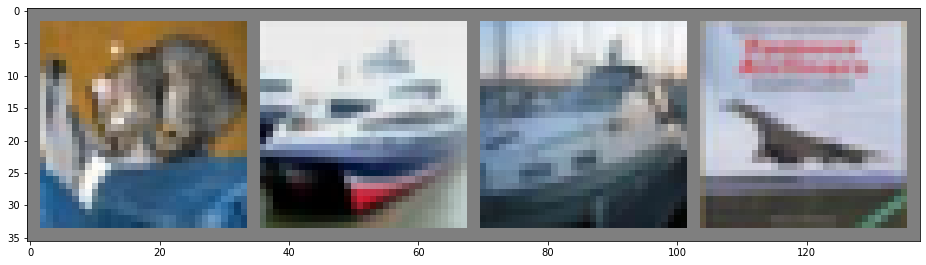

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  bird plane


In [5]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

plt.figure(figsize=(16, 16))
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [6]:
def visualize(images, ind):
    input = images[ind].unsqueeze(0)
    input.requires_grad = True
    
    def attribute_image_features(algorithm, input, **kwargs):
        net.zero_grad()
        tensor_attributions = algorithm.attribute(input,
                                                target=labels[ind],
                                                **kwargs
                                                )
        
        return tensor_attributions
    
    saliency = Saliency(net)
    grads = saliency.attribute(input, target=labels[ind].item())
    grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

    ig = IntegratedGradients(net)
    attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
    attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))

    ig = IntegratedGradients(net)
    nt = NoiseTunnel(ig)
    attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                        nt_samples=100, stdevs=0.2)
    attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

    dl = DeepLift(net)
    attr_dl = attribute_image_features(dl, input, baselines=input * 0)
    attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

    input = images[ind].unsqueeze(0)
    input.requires_grad = True
    print('Original Image')
    print('Predicted:', classes[predicted[ind]], 
        ' Probability:', torch.max(F.softmax(outputs, 1)).item())

    original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

    _ = viz.visualize_image_attr(None, original_image, 
                        method="original_image", title="Original Image")

    _ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                            show_colorbar=True, title="Overlayed Gradient Magnitudes")

    _ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                            show_colorbar=True, title="Overlayed Integrated Gradients")

    _ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                                outlier_perc=10, show_colorbar=True, 
                                title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

    _ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                            title="Overlayed DeepLift")
    return None

Original Image
Predicted: cat  Probability: 0.8101122379302979


/home/klaus/anaconda3/envs/pytorch/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:307: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


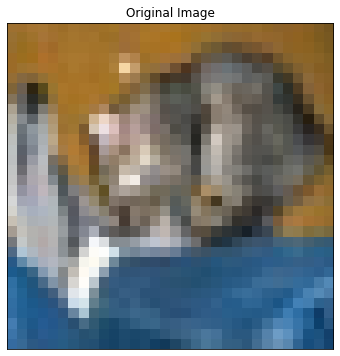

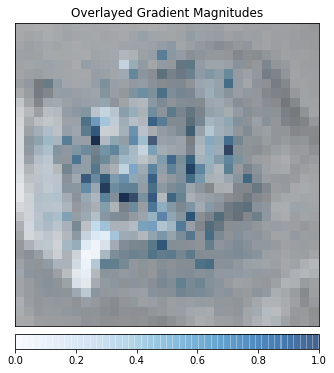

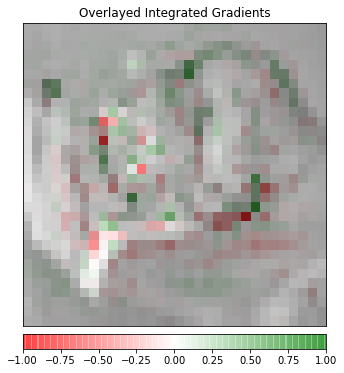

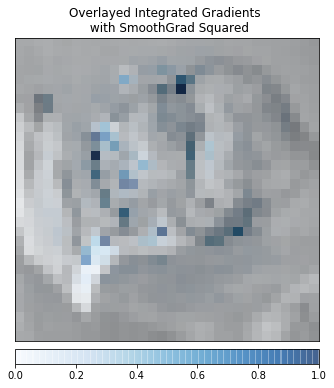

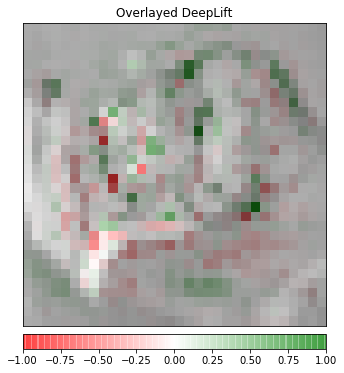

Original Image
Predicted: ship  Probability: 0.8101122379302979


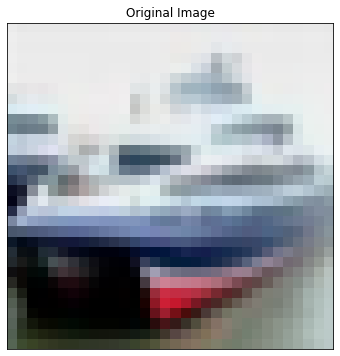

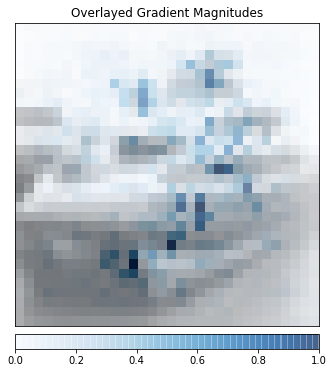

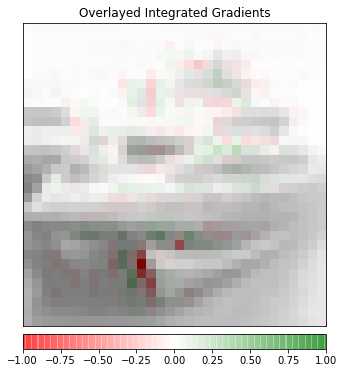

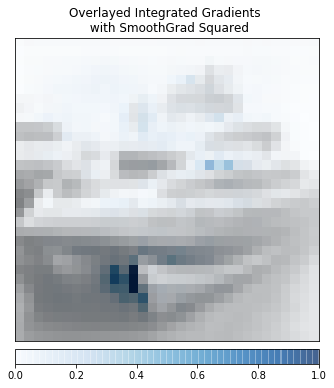

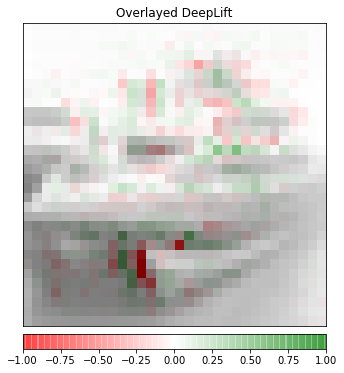

Original Image
Predicted: bird  Probability: 0.8101122379302979


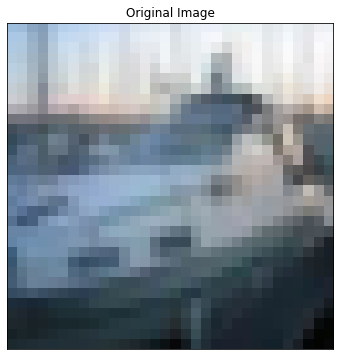

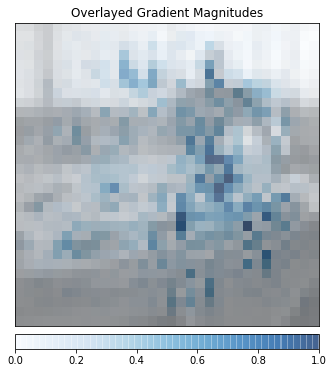

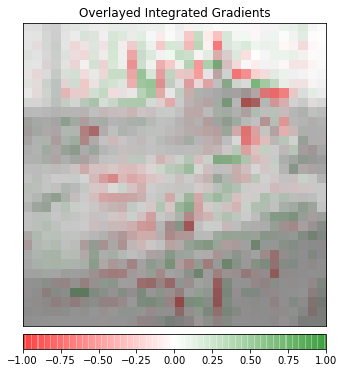

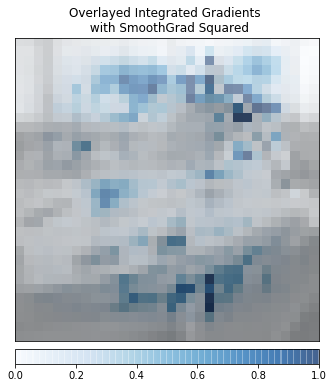

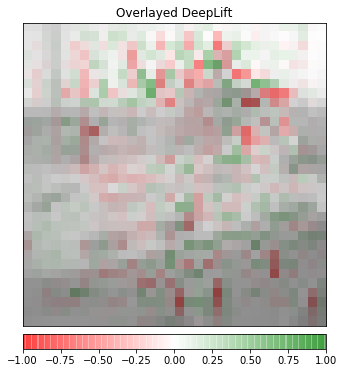

Original Image
Predicted: plane  Probability: 0.8101122379302979


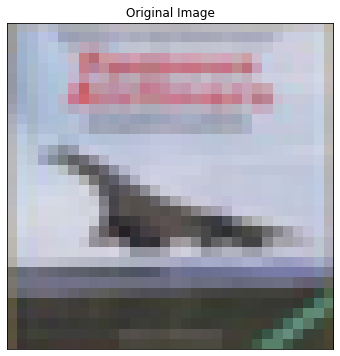

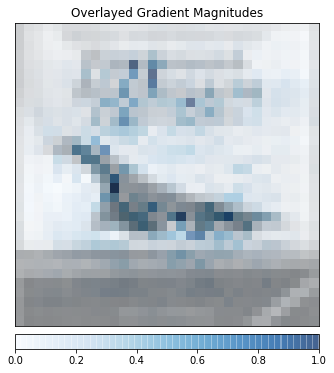

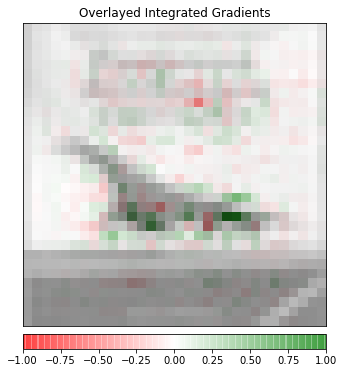

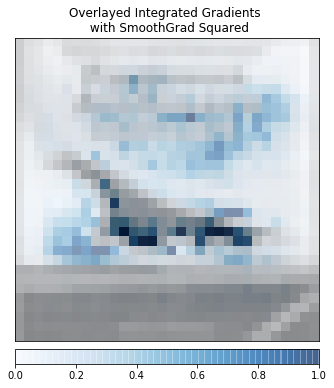

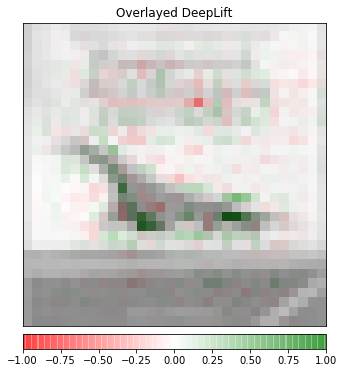

In [7]:
for i in range(4):
    visualize(images, i)

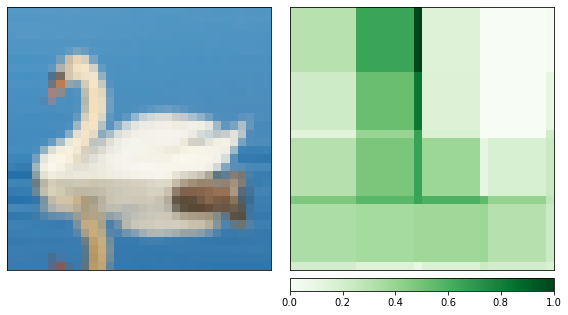

In [16]:
transform = transforms.Compose([
 transforms.Resize(32),
 transforms.CenterCrop(32),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )
from PIL import Image
img = Image.open('img/gooes.png').convert('RGB')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

output = net(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()

occlusion = Occlusion(net)


attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

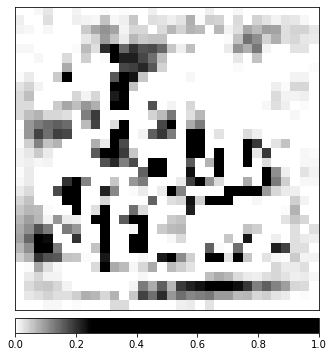

In [18]:
integrated_gradients = IntegratedGradients(net)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

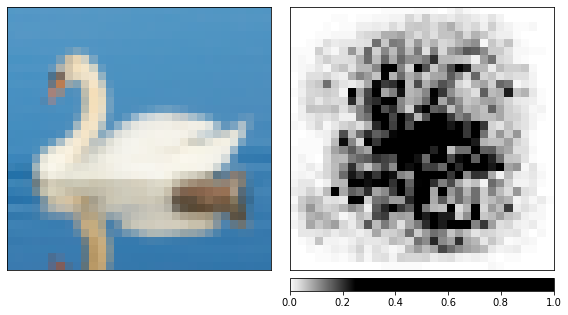

In [19]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


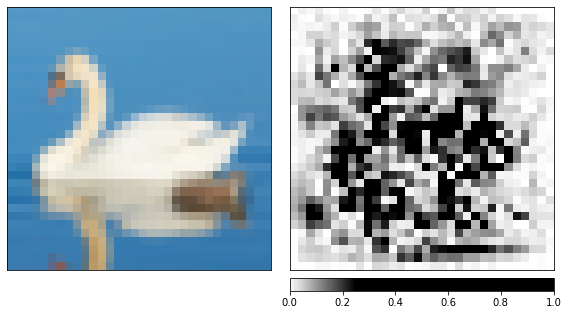

In [21]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(net)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)